First import everything that will be needed.

In [1]:
# Imports
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

## Node Positions
Get the locations of the nodes in the simulation. There will be one row for every location given in 3D cartesian coordinates.

In [2]:
# Code for single import
df = pd.read_csv("field-3d-000050.vtk", delimiter='\s+', index_col=False,nrows=676373, usecols=[0,1,2])
nodePositions = df.iloc[5:]
nodePositions.columns = ['x', 'y','z']
nodePositions.reset_index(drop=True,inplace=True)
nodePositions = nodePositions.convert_objects(convert_numeric=True)

/home/rhys/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [3]:
nodePositions.iloc[5677-3:5677+3,:]

,x,y,z
5674,1.546256,0.001500,-3.115321
5675,1.595344,0.001500,-3.115321
5676,-1.595344,0.004563,-3.115321
5677,-1.546256,0.004563,-3.115321
5678,-1.497169,0.004563,-3.115321
5679,-1.448081,0.004563,-3.115321


In [4]:
nodePositions.tail()

,x,y,z
676363,1.398994,1.004,3.167679
676364,1.448081,1.004,3.167679
676365,1.497169,1.004,3.167679
676366,1.546256,1.004,3.167679
676367,1.595344,1.004,3.167679


## Prepare for Calculation

In [5]:
# Define dx, dy, dz
dx = 0.0490875
dz = 0.05235833333

# Find the unique values in z
uniqueY = nodePositions.y.unique()

# Find the differences between the nodes
diffY = np.diff(uniqueY)

In [6]:
print(uniqueY)

[-0.0015      0.0015      0.0045628   0.00775382  0.01107843  0.01454222
  0.01815103  0.02191092  0.02582821  0.0299095   0.03416166  0.03859182
  0.04320746  0.04801633  0.05302652  0.05824646  0.06368493  0.06935108
  0.07525445  0.08140495  0.08781295  0.09448921  0.101445    0.1086919
  0.1162423   0.1241088   0.1323045   0.1408434   0.1497398   0.1590086
  0.1686655   0.1787266   0.1892089   0.2001301   0.2115085   0.2233633
  0.2357143   0.2485824   0.2619892   0.2759573   0.2905102   0.3056724
  0.3214692   0.3379275   0.3550747   0.3729398   0.3910278   0.41
  0.43        0.45        0.47        0.49        0.51        0.53
  0.55        0.57        0.59        0.61        0.63        0.65
  0.67        0.69        0.71        0.73        0.75        0.77
  0.79        0.8091205   0.8269121   0.8437879   0.8597565   0.8748665
  0.8891641   0.9026931   0.9154946   0.9276079   0.9390699   0.9499157
  0.9601783   0.9698892   0.979078    0.9877727   0.996       1.004     ]


In [7]:
diffY.shape

(83,)

In [8]:
# Find locations where y increases
locations = []
for r in range(len(nodePositions+1)):
    if nodePositions.iloc[r,1] > nodePositions.iloc[r-1,1]:
        locations.append(r)
locations = np.asanyarray(locations)

In [9]:
locations

array([    66,    132,    198, ..., 676170, 676236, 676302])

In [10]:
# Find an array of all the positions of x ghost nodes
xGhostNodes1 = np.where(nodePositions.iloc[:,0]==-1.595344)
xGhostNodes2 = np.where(nodePositions.iloc[:,0]==1.595344)
xGhostNodes1 = np.asanyarray(xGhostNodes1)
xGhostNodes2 = np.asanyarray(xGhostNodes2)
xGhostNodes = np.concatenate([xGhostNodes1,xGhostNodes2], axis=1)
xGhostNodes.shape

# Find an array of all the positions of y ghost nodes
yGhostNodes1 = np.where(nodePositions.iloc[:,1]==-0.0015)
yGhostNodes2 = np.where(nodePositions.iloc[:,1]==1.004)
yGhostNodes1 = np.asanyarray(yGhostNodes1)
yGhostNodes2 = np.asanyarray(yGhostNodes2)
yGhostNodes = np.concatenate([yGhostNodes1,yGhostNodes2], axis=1)
yGhostNodes.shape

# Find an array of all the positions of z ghost nodes
zGhostNodes1 = np.where(nodePositions.iloc[:,2]==-3.167679)
zGhostNodes2 = np.where(nodePositions.iloc[:,2]==3.167679)
zGhostNodes1 = np.asanyarray(zGhostNodes1)
zGhostNodes2 = np.asanyarray(zGhostNodes2)
zGhostNodes = np.concatenate([zGhostNodes1,zGhostNodes2], axis=1)
zGhostNodes.shape

ghostNodesRows = np.concatenate([xGhostNodes,yGhostNodes,zGhostNodes],axis=1)
ghostNodesRows.shape

(1, 47688)

## Multiple File Input and Calculation
Calculate S, R and using these, the basis tensors and invariants. 

###  10 Files

Check dy think that might be wrong

In [11]:
%%time

# Create a blank dataframe
df_combined = pd.DataFrame()

# Go through all the files
for x in range(40,50):
    
    # Read in the file
    df = pd.read_csv("field-3d-0000"+str(x)+".vtk", delimiter='\s+', index_col=False, skiprows=4058227, usecols=[0,1,2])
    df.columns = ['u', 'v','w']
    df.reset_index(drop=True,inplace=True)
    df = df.convert_objects(convert_numeric=True)
    df['file']="0000"+str(x)
    
    # Calculate rotation, strain, invariants, basis tensors for that given file
    index = 0
    
    # Keep track of the current node position
    #i = 0
    
    for r in range(len(df)):      
        
        # If in a ghost node position - assign temporarily a value of 0
        if r not in ghostNodesRows:

            # Check if current r is greater than current change over point
            #if r > locations[index]:              
                
             #   if index == 82:
            #        index = 0
                
                # If it is, update the current index
              #  index = index + 1
               # print(index)
                # Find the new dy
                #dy = diffY[index] + diffY[index-1]
            
            #print(r)
            
            # Get the current y spacing
            dy = nodePositions.iloc[r+66,1]-nodePositions.iloc[r-66,1]
            
            # Find rxy and add to array and dataframe
            rxy = 0.5*((df.iloc[r+66,0]-df.iloc[r-66,0])/(dy)-(df.iloc[r+1,1]-df.iloc[r-1,1])/(2*dx))
            df.set_value(r, 'rxy', rxy)
            
            # Find rxz and add to dataframe
            rxz = 0.5*((df.iloc[r+5544,0]-df.iloc[r-5544,0])/(2*dz)-(df.iloc[r+1,2]-df.iloc[r-1,2])/(2*dx))
            df.set_value(r, 'rxz', rxz)
         
            # Find ryz and add to dataframe
            ryz = 0.5*((df.iloc[r+5544,1]-df.iloc[r-5544,1])/(2*dz)-(df.iloc[r+66,2]-df.iloc[r-66,2])/(dy))
            df.set_value(r, 'ryz', ryz)
            
            # Find rxy and add to array and dataframe
            ryx = 0.5*(-1*(df.iloc[r+66,0]-df.iloc[r-66,0])/(dy)+(df.iloc[r+1,1]-df.iloc[r-1,1])/(2*dx))
            df.set_value(r, 'ryx', ryx)
            
            # Find rxz and add to dataframe
            rzx = 0.5*(-1*(df.iloc[r+5544,0]-df.iloc[r-5544,0])/(2*dz)+(df.iloc[r+1,2]-df.iloc[r-1,2])/(2*dx))
            df.set_value(r, 'rzx', rzx)
         
            # Find ryz and add to dataframe
            rzy = 0.5*(-1*(df.iloc[r+5544,1]-df.iloc[r-5544,1])/(2*dz)+(df.iloc[r+66,2]-df.iloc[r-66,2])/(dy))
            df.set_value(r, 'rzy', rzy)
      
            # Add the principle rotations
            df.set_value(r, 'rxx', 0)
            df.set_value(r, 'ryy', 0)
            df.set_value(r, 'rzz', 0)
            
            # Strain in xy
            sxy = 0.5*((df.iloc[r+66,0]-df.iloc[r-66,0])/(dy)+(df.iloc[r+1,1]-df.iloc[r-1,1])/(2*dx))
            df.set_value(r, 'sxy', sxy)
            
            # Find sxz and add to dataframe
            sxz = 0.5*((df.iloc[r+5544,0]-df.iloc[r-5544,0])/(2*dz)+(df.iloc[r+1,2]-df.iloc[r-1,2])/(2*dx))
            df.set_value(r, 'sxz', sxz)
            
            # Find syz and add to dataframe
            syz = 0.5*((df.iloc[r+5544,1]-df.iloc[r-5544,1])/(2*dz)+(df.iloc[r+66,2]-df.iloc[r-66,2])/(dy))
            df.set_value(r, 'syz', syz)
            
            # Find the principal strains
            sxx = (df.iloc[r+1,0] - df.iloc[r-1,0])/(2*dx)
            syy = (df.iloc[r+66,1] - df.iloc[r-66,1])/(dy)
            szz = (df.iloc[r+5544,2] - df.iloc[r-5544,2])/(2*dz)
            df.set_value(r, 'sxx', sxx)
            df.set_value(r, 'syy', syy)
            df.set_value(r, 'szz', szz)
           
            # Build the rotation and strain matricies
            rotation_matrix = np.matrix([[df.iloc[r,10], df.iloc[r,4], df.iloc[r,5]], [df.iloc[r,7], df.iloc[r,11], df.iloc[r,6]], [df.iloc[r,8], df.iloc[r,9], df.iloc[r,12]]])
            strain_matrix = np.matrix([[df.iloc[r,16], df.iloc[r,13], df.iloc[r,14]], [df.iloc[r,13], df.iloc[r,17], df.iloc[r,15]], [df.iloc[r,14], df.iloc[r,15], df.iloc[r,18]]])

            # Find the tensors
            V1 = strain_matrix
            V2 = strain_matrix * rotation_matrix - rotation_matrix * strain_matrix
            V3 = strain_matrix * strain_matrix - (1/3) * np.identity(3) * np.trace(strain_matrix * strain_matrix)

            # Find the invariants
            I1 = np.trace(strain_matrix * strain_matrix)
            I2 = np.trace(rotation_matrix * rotation_matrix)

            # Add everything back to the dataframe
            df.set_value(r, 'V1xx', V1[0,0])
            df.set_value(r, 'V1xy', V1[0,1])
            df.set_value(r, 'V1xz', V1[0,2])
            df.set_value(r, 'V1yx', V1[1,0])
            df.set_value(r, 'V1yy', V1[1,1])
            df.set_value(r, 'V1yz', V1[1,2])
            df.set_value(r, 'V1zx', V1[2,0])
            df.set_value(r, 'V1zy', V1[2,1])
            df.set_value(r, 'V1zz', V1[2,2])

            df.set_value(r, 'V2xx', V2[0,0])
            df.set_value(r, 'V2xy', V2[0,1])
            df.set_value(r, 'V2xz', V2[0,2])
            df.set_value(r, 'V2yx', V2[1,0])
            df.set_value(r, 'V2yy', V2[1,1])
            df.set_value(r, 'V2yz', V2[1,2])
            df.set_value(r, 'V2zx', V2[2,0])
            df.set_value(r, 'V2zy', V2[2,1])
            df.set_value(r, 'V2zz', V2[2,2])

            df.set_value(r, 'V3xx', V3[0,0])
            df.set_value(r, 'V3xy', V3[0,1])
            df.set_value(r, 'V3xz', V3[0,2])
            df.set_value(r, 'V3yx', V3[1,0])
            df.set_value(r, 'V3yy', V3[1,1])
            df.set_value(r, 'V3yz', V3[1,2])
            df.set_value(r, 'V3zx', V3[2,0])
            df.set_value(r, 'V3zy', V3[2,1])
            df.set_value(r, 'V3zz', V3[2,2])

            df.set_value(r, 'I1', I1)
            df.set_value(r, 'I2', I2)  
    
    # Combine this file to the larger data set
    df_combined = pd.concat([df_combined, df])
    print(x)

/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launch

/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


40
41
42
43
44
45
46
47
48
49
CPU times: user 1h 5min 24s, sys: 37.7 s, total: 1h 6min 2s
Wall time: 1h 6min 4s


In [12]:
# Save this dataframe so I only have to do it once
df_combined.to_csv('df_combined2')

# Start Here If Need More Data

In [13]:
# Read in the file
df_combined = pd.read_csv('df_combined2')
df_combined.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df_combined.tail()

,index,u,v,w,file,rxy,rxz,ryz,ryx,rzx,rzy,rxx,ryy,rzz,sxy,sxz,syz,sxx,syy,szz,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2
6763675,676363,0.942897,-5.845830e-15,19.46342,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6763676,676364,1.064567,-6.511544e-16,19.42357,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6763677,676365,0.982030,-2.575545e-14,19.42319,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6763678,676366,0.802401,-1.378752e-14,19.48736,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6763679,676367,0.712922,-3.953568e-14,19.60478,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Reynolds Stress
Try calculating the Reynolds Stress using the method given by Michael on 28/06 in the meeting.
1. Average on x-z plane for a given file (there should be 84 to find the average of)
2. Repeat step 1 for each file
3. Find the average for each plane across the files
4. Find the individual fluctuations from these averages

In [14]:
%%time
# Find the unique files in this dataframe
uniqueFiles = df_combined.file.unique()

# Build the matrix of values
averageMatrixU = np.zeros((len(uniqueY),len(uniqueFiles)+1))
averageMatrixV = np.zeros((len(uniqueY),len(uniqueFiles)+1))
averageMatrixW = np.zeros((len(uniqueY),len(uniqueFiles)+1))

# Plane count
r = 0

# Go through all the values of uniqueY
for y in uniqueY:
    
    # Filter the dataframe for that particular value of Y
    #print(y)

    # Filter the nodePositions dataframe based on y
    nodePositions_filtered = nodePositions[nodePositions.y == y]

    # Get a list of index values where the above is true
    # The max index value is going to be 217799 (since it's taken from nodePositions df)
    index_values = nodePositions_filtered.index
    index_values = np.asarray(index_values) # convert to numpy array 

    # Filter the combined dataframe based on the index_values selected
    df_combined_plane = df_combined.loc[df_combined['index'].isin(index_values)]  
    
    # We now have a dataframe consisting of only those observations on that particular y value across all the files
    
    # File count
    c = 0
    
    # Filter again by file
    for file in uniqueFiles:
        
        # Filter based on file
        df_combined_plane_file = df_combined_plane.loc[df_combined_plane.file == file]
        
        # Find the mean for this given y on this given file
        averageMatrixU[r,c] = df_combined_plane_file['u'].mean()
        averageMatrixV[r,c] = df_combined_plane_file['v'].mean()
        averageMatrixW[r,c] = df_combined_plane_file['w'].mean()
        
        # Update the file count
        c = c + 1
        
    # We have finished the plane, go to the next one
    r = r + 1
    
# For each row (plane), find the average and store in the last column
for r in range(len(averageMatrixU)):
    
    # Keep track of the average in that row
    totalU = 0
    totalV = 0
    totalW = 0
    count = 0
    
    # Go through all the columns
    for c in range(np.size(averageMatrixU,1)-1):
    
        totalU = totalU + averageMatrixU[r,c]
        totalV = totalV + averageMatrixV[r,c]
        totalW = totalW + averageMatrixW[r,c]
        count = count + 1
        
    # End of the columns so find the averages
    averageMatrixU[r,c+1] = totalU/count
    averageMatrixV[r,c+1] = totalV/count
    averageMatrixW[r,c+1] = totalW/count

CPU times: user 27.6 s, sys: 217 µs, total: 27.6 s
Wall time: 27.6 s


In [15]:
%%time
# Blank dataframes
df_u_mean = pd.DataFrame()
df_v_mean = pd.DataFrame()
df_w_mean = pd.DataFrame()

# Count what row we're on
r = 0

# Go through all the values of uniqueY
for y in uniqueY:
    
    # Filter the dataframe for that particular value of Y
    #print(y)

    # Filter the nodePositions dataframe based on y
    nodePositions_filtered = nodePositions[nodePositions.y == y]

    # Get a list of index values where the above is true
    index_values = nodePositions_filtered.index
    index_values = np.asarray(index_values) # convert to numpy array 

    # Filter the combined dataframe based on the index_values selected
    df_combined_plane = df_combined.loc[df_combined['index'].isin(index_values)] 
    
    # Add the mean for that plane to the dataframe
    df_combined_plane['u_mean'] = averageMatrixU[r,np.size(averageMatrixU,1)-1]
    df_combined_plane['v_mean'] = averageMatrixV[r,np.size(averageMatrixV,1)-1]
    df_combined_plane['w_mean'] = averageMatrixW[r,np.size(averageMatrixW,1)-1]

    # Add to another dataframe    
    df_u_mean = df_u_mean.append(df_combined_plane[['file','u_mean']])
    df_v_mean = df_v_mean.append(df_combined_plane[['file','v_mean']])
    df_w_mean = df_w_mean.append(df_combined_plane[['file','w_mean']])
    
    # Update the row
    r = r + 1

### CHECK STEPS BELOW ###
    
# Merge into a combined dataframe
df_u_mean['index'] = df_u_mean.index
df_u_mean_sorted = df_u_mean.sort_values(['file','index'], ascending=[True, True])
u_mean_array = np.asarray(df_u_mean_sorted[['u_mean']])
df_combined['u_mean'] = u_mean_array

df_v_mean['index'] = df_v_mean.index
df_v_mean_sorted = df_v_mean.sort_values(['file','index'], ascending=[True, True])
v_mean_array = np.asarray(df_v_mean_sorted[['v_mean']])
df_combined['v_mean'] = v_mean_array

df_w_mean['index'] = df_w_mean.index
df_w_mean_sorted = df_w_mean.sort_values(['file','index'], ascending=[True, True])
w_mean_array = np.asarray(df_w_mean_sorted[['w_mean']])
df_combined['w_mean'] = w_mean_array

/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

CPU times: user 40.2 s, sys: 448 ms, total: 40.7 s
Wall time: 40.7 s


In [16]:
# Find the fluctuations at each point
df_combined['u_fluct'] = df_combined['u'] - df_combined['u_mean']
df_combined['v_fluct'] = df_combined['v'] - df_combined['v_mean']
df_combined['w_fluct'] = df_combined['w'] - df_combined['w_mean']

# Blank dataframes
#df_Re_xy = pd.DataFrame()
#df_Re_xz = pd.DataFrame()
df_Re_yz = pd.DataFrame()
#df_Re_xx = pd.DataFrame()
#df_Re_yy = pd.DataFrame()
#df_Re_zz = pd.DataFrame()
df_tke = pd.DataFrame()

# Go through all the values of uniqueY
for y in uniqueY:
    
    # Filter the dataframe for that particular value of y
    print(y)

    # Filter the nodePositions dataframe based on y
    nodePositions_filtered = nodePositions[nodePositions.y == y]

    # Get a list of index values where the above is true
    index_values = nodePositions_filtered.index
    index_values = np.asarray(index_values) # convert to numpy array 

    # Filter the combined dataframe based on the index_values selected
    df_combined_plane = df_combined.loc[df_combined['index'].isin(index_values)]     

    ### RE STRESSES ###
    
    # Multiply the fluctuations
    #df_combined_plane['u_v_fluct']=df_combined_plane['u_fluct']*df_combined_plane['v_fluct']
    #df_combined_plane['u_w_fluct']=df_combined_plane['u_fluct']*df_combined_plane['w_fluct']
    df_combined_plane['v_w_fluct']=df_combined_plane['v_fluct']*df_combined_plane['w_fluct']
    #df_combined_plane['u_u_fluct']=df_combined_plane['u_fluct']*df_combined_plane['u_fluct']
    #df_combined_plane['v_v_fluct']=df_combined_plane['v_fluct']*df_combined_plane['v_fluct']
    #df_combined_plane['w_w_fluct']=df_combined_plane['w_fluct']*df_combined_plane['w_fluct']

    # Find the reynolds stresses
    #df_combined_plane['Re_xy']=df_combined_plane['u_v_fluct'].mean()
    #df_combined_plane['Re_xz']=df_combined_plane['u_w_fluct'].mean()
    df_combined_plane['Re_yz']=df_combined_plane['v_w_fluct'].mean()
    #df_combined_plane['Re_xx']=df_combined_plane['u_u_fluct'].mean()
    #df_combined_plane['Re_yy']=df_combined_plane['v_v_fluct'].mean()
    #df_combined_plane['Re_zz']=df_combined_plane['w_w_fluct'].mean()

    
    #df_Re_xy = df_Re_xy.append(df_combined_plane[['file','Re_xy']])
    #df_Re_xz = df_Re_xz.append(df_combined_plane[['file','Re_xz']])
    df_Re_yz = df_Re_yz.append(df_combined_plane[['file','Re_yz']])
    #df_Re_xx = df_Re_xx.append(df_combined_plane[['file','Re_xx']])
    #df_Re_yy = df_Re_yy.append(df_combined_plane[['file','Re_yy']])
    #df_Re_zz = df_Re_zz.append(df_combined_plane[['file','Re_zz']])
    
    ### TKE ###
    
    # Find the fluctuation squared
    df_combined_plane['u_fluct_squared']=df_combined_plane['u_fluct']**2
    df_combined_plane['v_fluct_squared']=df_combined_plane['v_fluct']**2
    df_combined_plane['w_fluct_squared']=df_combined_plane['w_fluct']**2
    
    # Find the means of the fluctuating parts
    u_fluct_squared_mean = df_combined_plane['u_fluct_squared'].mean()
    v_fluct_squared_mean = df_combined_plane['v_fluct_squared'].mean()
    w_fluct_squared_mean = df_combined_plane['w_fluct_squared'].mean()

    # Find the TKE
    tke = 0.5*(u_fluct_squared_mean+v_fluct_squared_mean+w_fluct_squared_mean)
    df_combined_plane['tke']=tke
    
    df_tke = df_tke.append(df_combined_plane[['file','tke']])
    
# Merge into a combined dataframe
# df_Re_xy['index'] = df_Re_xy.index
# df_Re_xy_sorted = df_Re_xy.sort_values(['file','index'], ascending=[True, True])
# Re_xy_array = np.asarray(df_Re_xy_sorted[['Re_xy']])
# df_combined['Re_xy'] = Re_xy_array

# df_Re_xz['index'] = df_Re_xz.index
# df_Re_xz_sorted = df_Re_xz.sort_values(['file','index'], ascending=[True, True])
# Re_xz_array = np.asarray(df_Re_xz_sorted[['Re_xz']])
# df_combined['Re_xz'] = Re_xz_array


df_Re_yz['index'] = df_Re_yz.index
df_Re_yz_sorted = df_Re_yz.sort_values(['file','index'], ascending=[True, True])
Re_yz_array = np.asarray(df_Re_yz_sorted[['Re_yz']])
df_combined['Re_yz'] = Re_yz_array

# df_Re_xx['index'] = df_Re_xx.index
# df_Re_xx_sorted = df_Re_xx.sort_values(['file','index'], ascending=[True, True])
# Re_xx_array = np.asarray(df_Re_xx_sorted[['Re_xx']])
# df_combined['Re_xx'] = Re_xx_array

# df_Re_yy['index'] = df_Re_yy.index
# df_Re_yy_sorted = df_Re_yy.sort_values(['file','index'], ascending=[True, True])
# Re_yy_array = np.asarray(df_Re_yy_sorted[['Re_yy']])
# df_combined['Re_yy'] = Re_yy_array

# df_Re_zz['index'] = df_Re_zz.index
# df_Re_zz_sorted = df_Re_zz.sort_values(['file','index'], ascending=[True, True])
# Re_zz_array = np.asarray(df_Re_zz_sorted[['Re_zz']])
# df_combined['Re_zz'] = Re_zz_array

df_tke['index'] = df_tke.index
df_tke_sorted = df_tke.sort_values(['file','index'], ascending=[True, True])
tke_array = np.asarray(df_tke_sorted[['tke']])
df_combined['tke'] = tke_array

-0.0015


/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

0.0015
0.004562797
0.007753817
0.01107843
0.01454222
0.01815103
0.02191092
0.02582821
0.0299095
0.03416166
0.03859182
0.04320746
0.04801633
0.05302652
0.05824646
0.06368493
0.06935108
0.07525445
0.08140495
0.08781295
0.09448921
0.10144500000000001
0.10869189999999998
0.1162423
0.12410879999999999
0.13230450000000002
0.1408434
0.14973979999999998
0.1590086
0.1686655
0.1787266
0.18920889999999999
0.2001301
0.21150850000000002
0.2233633
0.23571430000000002
0.2485824
0.26198920000000003
0.27595729999999996
0.29051020000000005
0.3056724
0.3214692
0.3379275
0.3550747
0.3729398
0.3910278
0.41
0.43
0.45
0.47
0.49
0.51
0.53
0.55
0.57
0.59
0.61
0.63
0.65
0.67
0.69
0.71
0.73
0.75
0.77
0.79
0.8091205
0.8269120999999999
0.8437879
0.8597565
0.8748665000000001
0.8891641
0.9026931
0.9154945999999999
0.9276078999999999
0.9390699
0.9499156999999999
0.9601783000000002
0.9698892
0.9790780000000001
0.9877727
0.996
1.004


In [17]:
df_combined.tail()

,index,u,v,w,file,rxy,rxz,ryz,ryx,rzx,rzy,rxx,ryy,rzz,sxy,sxz,syz,sxx,syy,szz,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,u_mean,v_mean,w_mean,u_fluct,v_fluct,w_fluct,Re_yz,tke
6763675,676363,0.942897,-5.845830e-15,19.46342,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.947217,-5.864105e-15,0.139105,3.872909e-17,0.732741
6763676,676364,1.064567,-6.511544e-16,19.42357,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,1.068886,-6.694295e-16,0.099255,3.872909e-17,0.732741
6763677,676365,0.982030,-2.575545e-14,19.42319,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.986350,-2.577373e-14,0.098875,3.872909e-17,0.732741
6763678,676366,0.802401,-1.378752e-14,19.48736,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.806721,-1.380580e-14,0.163045,3.872909e-17,0.732741
6763679,676367,0.712922,-3.953568e-14,19.60478,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.717241,-3.955396e-14,0.280465,3.872909e-17,0.732741


### Reynolds Stress Anisotropy Tensor
The following section is finding $a_{\alpha \beta} = \tau_{\alpha \beta}/2k - 1/3*k*\delta_{\alpha \beta}$

In [18]:
# In the shear directions
#df_combined['a_xy'] = df_combined['Re_xy']/(2*df_combined['tke'])
#df_combined['a_xz'] = df_combined['Re_xz']/(2*df_combined['tke'])
df_combined['a_yz'] = df_combined['Re_yz']/(2*df_combined['tke'])

# In the principal directions
# df_combined['a_xx'] = df_combined['Re_xx']/(2*df_combined['tke']) - 1/3*df_combined['tke']
# df_combined['a_yy'] = df_combined['Re_yy']/(2*df_combined['tke']) - 1/3*df_combined['tke']
# df_combined['a_zz'] = df_combined['Re_zz']/(2*df_combined['tke']) - 1/3*df_combined['tke']

df_combined.iloc[3299+30100:3307+30100,:]

,index,u,v,w,file,rxy,rxz,ryz,ryx,rzx,rzy,rxx,ryy,rzz,sxy,sxz,syz,sxx,syy,szz,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,u_mean,v_mean,w_mean,u_fluct,v_fluct,w_fluct,Re_yz,tke,a_yz
33399,33399,0.154717,0.001458,1.236898,40,13.407385,-1.908756,-134.211199,-13.407385,1.908756,134.211199,0.0,0.0,0.0,13.610986,0.981256,134.249263,-0.233377,0.791986,0.395515,-0.233377,13.610986,0.981256,13.610986,0.791986,134.249263,0.981256,134.249263,0.395515,-361.229510,374.197288,-3625.477948,374.197288,36400.484526,-66.034897,-3625.477948,-66.034897,-36039.255016,-11953.393971,139.336176,1827.423916,139.336176,6069.080427,172.777045,1827.423916,172.777045,5884.313544,36419.010711,-36392.094714,0.002628,-0.000017,1.015208,0.152089,0.001475,0.221690,-0.000752,0.081263,-0.004627
33400,33400,0.042383,0.007394,1.485672,40,2.231520,-0.875384,-161.267966,-2.231520,0.875384,161.267966,0.0,0.0,0.0,2.193601,-0.193571,161.278584,-1.646375,2.566001,0.630501,-1.646375,2.193601,-0.193571,2.193601,2.566001,161.278584,-0.193571,161.278584,0.630501,-10.129029,100.563903,-711.660895,100.563903,52027.928653,-314.486302,-711.660895,-314.486302,-52017.799624,-17339.424979,-29.201576,353.977584,-29.201576,8675.193113,515.102765,353.977584,515.102765,8664.231866,52040.954661,-52026.205724,0.002628,-0.000017,1.015208,0.039755,0.007412,0.470464,-0.000752,0.081263,-0.004627
33401,33401,-0.006916,-0.002265,1.303835,40,-0.651411,3.514370,-146.270596,0.651411,-3.514370,146.270596,0.0,0.0,0.0,-0.800393,-4.061258,146.244007,0.619801,-1.190358,-0.315547,0.619801,-0.800393,-4.061258,-0.800393,-1.190358,146.244007,-4.061258,146.244007,-0.315547,27.502758,-1109.177371,215.626087,-1109.177371,42783.439041,127.791895,215.626087,127.791895,-42810.941800,-14252.744402,-593.477986,-118.288301,-593.477986,7119.104299,-216.978992,-118.288301,-216.978992,7133.640104,42810.789005,-42815.724788,0.002628,-0.000017,1.015208,-0.009544,-0.002248,0.288627,-0.000752,0.081263,-0.004627
33402,33402,0.103233,-0.007232,0.741935,40,11.064151,3.853706,-85.209348,-11.064151,-3.853706,85.209348,0.0,0.0,0.0,11.040128,-4.034087,85.215514,2.291411,-2.665947,-0.424180,2.291411,11.040128,-4.034087,11.040128,-2.665947,85.215514,-4.034087,85.215514,-0.424180,-213.206937,-617.288431,-1873.094394,-617.288431,14766.616098,188.931210,-1873.094394,188.931210,-14553.409161,-4793.998463,-347.901694,933.257645,-347.901694,2453.268195,-307.863614,933.257645,-307.863614,2340.730267,14812.221952,-14795.799045,0.002628,-0.000017,1.015208,0.100604,-0.007214,-0.273273,-0.000752,0.081263,-0.004627
33403,33403,0.218044,-0.004624,0.529451,40,21.598393,1.017288,-60.958475,-21.598393,-1.017288,60.958475,0.0,0.0,0.0,21.670942,-1.292593,60.951968,1.537833,-1.638204,0.112042,1.537833,21.670942,-1.292593,21.670942,-1.638204,60.951968,-1.292593,60.951968,0.112042,-933.485145,-72.202923,-2636.041664,-72.202923,8367.193042,100.819995,-2636.041664,100.819995,-7433.707897,-2318.983579,-80.961210,1318.753919,-80.961210,1394.806823,-121.034252,1318.753919,-121.034252,924.176756,8377.947042,-8366.922194,0.002628,-0.000017,1.015208,0.215415,-0.004606,-0.485757,-0.000752,0.081263,-0.004627
33404,33404,0.254209,-0.000110,0.515162,40,24.992409,0.602732,-59.289987,-24.992409,-0.602732,59.289987,0.0,0.0,0.0,25.072716,-0.695479,59.252497,0.034318,-0.163244,0.203374,0.034318,25.072716,-0.695479,25.072716,-0.163244,59.252497,-0.695479,59.252497,0.203374,-1252.416772,-72.010772,-2967.525535,-72.010772,8279.414670,19.467192,-2967.525535,19.467192,-7026.997898,-2130.885895,-44.441416,1485.455743,-44.441416,1379.514298,-15.059801,1485.455743,-15.059801,751.371597,8280.035609,-8280.572581,0.002628,-0.000017,1.015208,0.251581,-0.000092,-0.500045,-0.000752,0.081263,-0.004627
33405,33405,0.221413,0.003261,0.401999,40,22.712468,0.415045,-46.110958,-22.712468,-0.415045,46.110958,0.0,0.0,0.0,22.759250,-0.057395,46.070921,-1.076379,1.037259,0.143615,-1.076379,22.

### Add y position

In [21]:
y_values = np.asarray(nodePositions.y)
y_values_repeated = np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(y_values,y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values)
df_combined['y'] = y_values_repeated
df_combined.head()

,index,u,v,w,file,rxy,rxz,ryz,ryx,rzx,rzy,rxx,ryy,rzz,sxy,sxz,syz,sxx,syy,szz,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,u_mean,v_mean,w_mean,u_fluct,v_fluct,w_fluct,Re_yz,tke,a_yz,y
0,0,0.0,0.0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0015
1,1,0.0,0.0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0015
2,2,0.0,0.0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0015
3,3,0.0,0.0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0015
4,4,0.0,0.0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0015


### Drop NaNs and Uneccessary Columns

In [22]:
# Remove the uneccessary columns
df_combined.drop(['rxy','rxz', 'ryz', 'ryx', 'rzx', 'rzy', 'rxx', 'ryy', 'rzz', 'sxy', 'sxz', 'syz', 'sxx', 'syy', 'szz'], axis = 1, inplace=True)
df_combined.tail()

,index,u,v,w,file,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,u_mean,v_mean,w_mean,u_fluct,v_fluct,w_fluct,Re_yz,tke,a_yz,y
6763675,676363,0.942897,-5.845830e-15,19.46342,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.947217,-5.864105e-15,0.139105,3.872909e-17,0.732741,2.642753e-17,1.004
6763676,676364,1.064567,-6.511544e-16,19.42357,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,1.068886,-6.694295e-16,0.099255,3.872909e-17,0.732741,2.642753e-17,1.004
6763677,676365,0.982030,-2.575545e-14,19.42319,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.986350,-2.577373e-14,0.098875,3.872909e-17,0.732741,2.642753e-17,1.004
6763678,676366,0.802401,-1.378752e-14,19.48736,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.806721,-1.380580e-14,0.163045,3.872909e-17,0.732741,2.642753e-17,1.004
6763679,676367,0.712922,-3.953568e-14,19.60478,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.717241,-3.955396e-14,0.280465,3.872909e-17,0.732741,2.642753e-17,1.004


In [23]:
df_combined.drop(['u_mean', 'v_mean', 'w_mean', 'u_fluct', 'v_fluct', 'w_fluct'], axis = 1, inplace= True)
df_combined.tail()

,index,u,v,w,file,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,Re_yz,tke,a_yz,y
6763675,676363,0.942897,-5.845830e-15,19.46342,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.872909e-17,0.732741,2.642753e-17,1.004
6763676,676364,1.064567,-6.511544e-16,19.42357,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.872909e-17,0.732741,2.642753e-17,1.004
6763677,676365,0.982030,-2.575545e-14,19.42319,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.872909e-17,0.732741,2.642753e-17,1.004
6763678,676366,0.802401,-1.378752e-14,19.48736,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.872909e-17,0.732741,2.642753e-17,1.004
6763679,676367,0.712922,-3.953568e-14,19.60478,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.872909e-17,0.732741,2.642753e-17,1.004


In [24]:
# Filter out the rows with NaN values
df_combined.dropna(inplace=True)
df_combined.tail()

,index,u,v,w,file,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,Re_yz,tke,a_yz,y
6758064,670752,0.826572,0.009703,19.45909,49,2.170863,-0.188150,-0.452201,-0.188150,-1.871412,0.121719,-0.452201,0.121719,0.418654,-0.264058,-1.278321,-0.233413,-1.278321,0.131678,0.296198,-0.233413,0.296198,0.132380,1.986032,-0.111383,-1.193884,-0.111383,0.585898,-0.091746,-1.193884,-0.091746,-2.571930,8.899506,-0.256095,-0.002216,0.733016,-0.001512,0.996
6758065,670753,0.968185,0.016772,19.42370,49,2.499189,-0.442243,-0.673191,-0.442243,-3.196522,0.026523,-0.673191,0.026523,0.570014,0.024550,-2.331569,0.556845,-2.331569,0.361995,0.067716,0.556845,0.067716,-0.386545,0.865528,0.290536,-2.077890,0.290536,4.384851,0.228052,-2.077890,0.228052,-5.250378,18.087553,-0.503892,-0.002216,0.733016,-0.001512,0.996
6758066,670754,1.071930,0.006593,19.36473,49,0.315735,-0.647662,-0.620124,-0.647662,-1.247228,-0.055473,-0.620124,-0.055473,1.003756,-0.189574,-0.570312,-0.240963,-0.570312,0.521681,-0.056535,-0.240963,-0.056535,-0.332107,-0.521954,0.637692,-0.782321,0.637692,0.552458,0.415137,-0.782321,0.415137,-0.030504,4.276987,-0.461083,-0.002216,0.733016,-0.001512,0.996
6758067,670755,0.999182,-0.007770,19.33705,49,-2.245605,-0.540932,-0.424848,-0.540932,1.484322,-0.031297,-0.424848,-0.031297,1.464332,-0.866098,1.699469,1.597763,1.699469,0.497343,0.429785,1.597763,0.429785,0.368755,2.069716,0.425099,0.348852,0.425099,-0.949331,0.137530,0.348852,0.137530,-1.120386,10.338390,-0.799306,-0.002216,0.733016,-0.001512,0.996
6758068,670756,0.851468,-0.001336,19.36557,49,-2.173524,-0.232191,-0.197902,-0.232191,0.305368,0.125390,-0.197902,0.125390,1.952220,-0.729503,1.158893,5.708488,1.158893,0.218486,0.588893,5.708488,0.588893,0.511016,1.868544,0.408954,0.014682,0.408954,-2.785855,0.329029,0.014682,0.329029,0.917312,8.846220,-4.084303,-0.002216,0.733016,-0.001512,0.996


## Save the Data

In [25]:
# Save this dataframe so I only have to do it once
df_combined.to_csv('df_combined_40to49_dropped_y')

### Open and Clean the data

In [12]:
df_combined = pd.read_csv('df_combined_40to49_dropped')
df_combined = df_combined.drop(['Unnamed: 0', ''], axis = 1)
df_combined.tail()

ValueError: labels [''] not contained in axis

In [5]:
#df_combined.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df_combined = df_combined.drop(['Unnamed: 0', ''], axis = 1)
df_combined.tail()

,index,index,u,v,w,file,rxy,rxz,ryz,rxx,ryy,rzz,sxy,sxz,syz,sxx,syy,szz,V1xx,V1xy,V1xz,V1yx,V1yy,V1yz,V1zx,V1zy,V1zz,V2xx,V2xy,V2xz,V2yx,V2yy,V2yz,V2zx,V2zy,V2zz,V3xx,V3xy,V3xz,V3yx,V3yy,V3yz,V3zx,V3zy,V3zz,I1,I2,u_mean,v_mean,w_mean,u_fluct,v_fluct,w_fluct,Re_xy,Re_xz,Re_yz,Re_xx,Re_yy,Re_zz,tke,a_xy,a_xz,a_yz,a_xx,a_yy,a_zz
6763675,6763675,676363,0.942897,-5.845830e-15,19.46342,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.947217,-5.864105e-15,0.139105,2.057370e-17,0.02651,3.872909e-17,0.59942,7.594302e-29,0.866063,0.732741,1.403886e-17,0.018089,2.642753e-17,0.164778,-0.244247,0.346727
6763676,6763676,676364,1.064567,-6.511544e-16,19.42357,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,1.068886,-6.694295e-16,0.099255,2.057370e-17,0.02651,3.872909e-17,0.59942,7.594302e-29,0.866063,0.732741,1.403886e-17,0.018089,2.642753e-17,0.164778,-0.244247,0.346727
6763677,6763677,676365,0.982030,-2.575545e-14,19.42319,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.986350,-2.577373e-14,0.098875,2.057370e-17,0.02651,3.872909e-17,0.59942,7.594302e-29,0.866063,0.732741,1.403886e-17,0.018089,2.642753e-17,0.164778,-0.244247,0.346727
6763678,6763678,676366,0.802401,-1.378752e-14,19.48736,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.806721,-1.380580e-14,0.163045,2.057370e-17,0.02651,3.872909e-17,0.59942,7.594302e-29,0.866063,0.732741,1.403886e-17,0.018089,2.642753e-17,0.164778,-0.244247,0.346727
6763679,6763679,676367,0.712922,-3.953568e-14,19.60478,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,1.827506e-17,19.324315,0.717241,-3.955396e-14,0.280465,2.057370e-17,0.02651,3.872909e-17,0.59942,7.594302e-29,0.866063,0.732741,1.403886e-17,0.018089,2.642753e-17,0.164778,-0.244247,0.346727


## Plot the Data to Check

### y vs Rwv

In [19]:
# Create a dataframe of results of Rxy and z
y_values = np.asarray(nodePositions.y)
y_values_repeated = np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(y_values,y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values)
df_plot = pd.DataFrame(y_values_repeated, columns=['y'])
values_to_add = np.asarray(df_Re_yz_sorted['Re_yz'])
df_plot['Re_yz'] = values_to_add
df_plot.tail()

,y,Re_yz
6763675,1.004,3.872909e-17
6763676,1.004,3.872909e-17
6763677,1.004,3.872909e-17
6763678,1.004,3.872909e-17
6763679,1.004,3.872909e-17


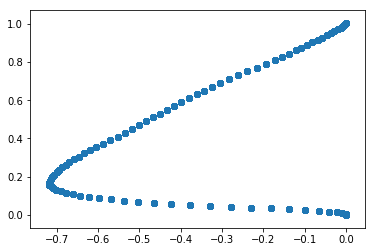

In [20]:
# Create a basic scatter plot
plt.scatter(df_plot.Re_yz,df_plot.y)
#plt.xlim(-0.0005,0.0005)

In [21]:
df_plot.describe()

,y,Re_yz
count,6.763680e+06,6.763680e+06
mean,4.061565e-01,-3.706687e-01
std,3.370997e-01,2.578702e-01
min,-1.500000e-03,-7.188375e-01
25%,9.282015e-02,-6.246262e-01
50%,3.135708e-01,-3.894117e-01
75%,7.150000e-01,-1.053539e-01
max,1.004000e+00,3.872909e-17


### y vs a_yz

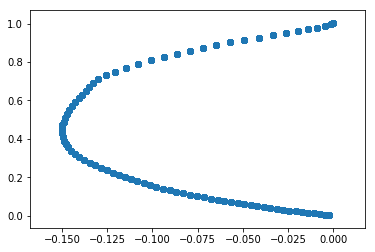

In [22]:
# Create a dataframe of results of Rxy and z
y_values = np.asarray(nodePositions.y)
y_values_repeated = np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(y_values,y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values)
df_plot = pd.DataFrame(y_values_repeated, columns=['y'])
values_to_add = np.asarray(df_combined['a_yz'])
df_plot['a_yz'] = values_to_add

# Create a basic scatter plot
plt.scatter(df_plot.a_yz,df_plot.y)

### y vs tke

In [64]:
# Create a dataframe of results of Rxy and z
y_values = np.asarray(nodePositions.y)
y_values_repeated = np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(np.append(y_values,y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values), y_values)
df_plot = pd.DataFrame(y_values_repeated, columns=['y'])
values_to_add = np.asarray(df_tke_sorted['tke'])
df_plot['df_tke_sorted'] = values_to_add
df_plot.tail()

,y,df_tke_sorted
6763675,1.004,0.732741
6763676,1.004,0.732741
6763677,1.004,0.732741
6763678,1.004,0.732741
6763679,1.004,0.732741


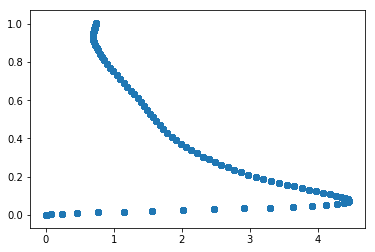

In [65]:
# Create a basic scatter plot
plt.scatter(df_plot.df_tke_sorted,df_plot.y)
#plt.xlim(-0.0005,0.0005)

In [66]:
df_plot.describe()

,y,df_tke_sorted
count,6.763680e+06,6.763680e+06
mean,4.061565e-01,2.059743e+00
std,3.370997e-01,1.336010e+00
min,-1.500000e-03,0.000000e+00
25%,9.282015e-02,8.147881e-01
50%,3.135708e-01,1.699746e+00
75%,7.150000e-01,3.224230e+00
max,1.004000e+00,4.461242e+00
